In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!pip install conllu

In [3]:
from conllu import parse

train_data = open('/kaggle/input/ud-english-ats/en_atis-ud-train.conllu')
dev_data = open('/kaggle/input/ud-english-ats/en_atis-ud-dev.conllu')
test_data = open('/kaggle/input/ud-english-ats/en_atis-ud-test.conllu')

train_data = train_data.read()
dev_data = dev_data.read()
test_data = test_data.read()

train_sentences = parse(train_data)
dev_sentences = parse(dev_data)
test_sentences = parse(test_data)

In [4]:
train_X = []
train_Y = []

dev_X = []
dev_Y = []

test_X = []
test_Y = []

for sentence in train_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity['form'])  # entity[0] contains the word
        Y_sentence.append(entity['upos'])  # entity[1] contains corresponding tag
        
    train_X.append(X_sentence)
    train_Y.append(Y_sentence)

for sentence in dev_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity['form'])  # entity[0] contains the word
        Y_sentence.append(entity['upos'])  # entity[1] contains corresponding tag
        
    dev_X.append(X_sentence)
    dev_Y.append(Y_sentence)

for sentence in test_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity['form'])  # entity[0] contains the word
        Y_sentence.append(entity['upos'])  # entity[1] contains corresponding tag
        
    test_X.append(X_sentence)
    test_Y.append(Y_sentence)

In [5]:
word_tokenizer = Tokenizer(oov_token = '<OOV>')                      # instantiate tokeniser
word_tokenizer.fit_on_texts(train_X + test_X + dev_X)                    # fit tokeniser on data
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_Y + test_Y + dev_Y)

train_X_encoded = word_tokenizer.texts_to_sequences(train_X)
train_Y_encoded = tag_tokenizer.texts_to_sequences(train_Y)

dev_X_encoded = word_tokenizer.texts_to_sequences(dev_X)
dev_Y_encoded = tag_tokenizer.texts_to_sequences(dev_Y)

test_X_encoded = word_tokenizer.texts_to_sequences(test_X)
test_Y_encoded = tag_tokenizer.texts_to_sequences(test_Y)


In [6]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

train_X_padded = pad_sequences(train_X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
train_Y_padded = pad_sequences(train_Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

dev_X_padded = pad_sequences(dev_X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
dev_Y_padded = pad_sequences(dev_Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

test_X_padded = pad_sequences(test_X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
test_Y_padded = pad_sequences(test_Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [7]:
train_X, train_Y = train_X_padded, train_Y_padded
dev_X, dev_Y = dev_X_padded, dev_Y_padded
test_X, test_Y = test_X_padded, test_Y_padded

In [8]:

path = '/kaggle/input/google-word2vec/GoogleNews-vectors-negative300.bin'
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

# assign word vectors from word2vec model
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))



Embeddings shape: (934, 300)


In [9]:
print(train_X.shape, train_Y.shape)
print(dev_X.shape, dev_Y.shape)
print(test_X.shape, test_Y.shape)

(4274, 100) (4274, 100)
(572, 100) (572, 100)
(586, 100) (586, 100)


In [10]:
tag2id = tag_tokenizer.word_index
tag2id['unk'] = 0
id2tag = {}
for tag,idx in tag2id.items():
    id2tag[idx] = tag

print(tag2id)
print(id2tag)
  

{'propn': 1, 'adp': 2, 'noun': 3, 'verb': 4, 'det': 5, 'pron': 6, 'aux': 7, 'adj': 8, 'num': 9, 'cconj': 10, 'adv': 11, 'part': 12, 'intj': 13, 'sym': 14, 'unk': 0}
{1: 'propn', 2: 'adp', 3: 'noun', 4: 'verb', 5: 'det', 6: 'pron', 7: 'aux', 8: 'adj', 9: 'num', 10: 'cconj', 11: 'adv', 12: 'part', 13: 'intj', 14: 'sym', 0: 'unk'}


In [11]:
# use Keras' to_categorical function to one-hot encode Y
train_Y = to_categorical(train_Y,num_classes= 15, dtype='int32')
dev_Y = to_categorical(dev_Y,num_classes= 15, dtype='int32')
test_Y = to_categorical(test_Y, num_classes= 15, dtype='int32')


In [12]:
print(train_X.shape, train_Y.shape)
print(dev_X.shape, dev_Y.shape)
print(test_X.shape, test_Y.shape)

(4274, 100) (4274, 100, 15)
(572, 100) (572, 100, 15)
(586, 100) (586, 100, 15)


# Vanilla RNN

In [13]:
# total number of tags
NUM_CLASSES = train_Y.shape[2]
print(NUM_CLASSES)

15


In [14]:
# create architecture
def create_run_model(EMBEDDING_SIZE, EPOCHS, MODEL_NAME):
    bidirect_model = Sequential()
    bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = MAX_SEQ_LENGTH,weights = [embedding_weights],
     trainable = True
    ))
    bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
    bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
    #compile model
    bidirect_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    # check summary of model
    bidirect_model.summary()
    
    rnn_training = bidirect_model.fit(train_X, train_Y, batch_size=128, epochs= EPOCHS, validation_data=(dev_X, dev_Y))

    # visualise training history
    plt.plot(rnn_training.history['acc'])
    plt.plot(rnn_training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()

    loss, accuracy = bidirect_model.evaluate(test_X, test_Y, verbose = 1)
    print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

    bidirect_model.save(MODEL_NAME)
    return bidirect_model

In [15]:
# create architecture with embedding size, hidden size, number of layers, learning rate, complexity of decoding network
def create_run_model2(EMBEDDING_SIZE,EPOCHS, MODEL_NAME):
    rnn_model = Sequential()

    # create embedding layer - usually the first layer in text problems
    rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                            output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                            input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                            trainable     =  True                    # False - don't update the embeddings
    ))

    # add an RNN layer which contains 64 RNN cells
    rnn_model.add(SimpleRNN(64, 
                  return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
    ))

    # add time distributed (output at each sequence) layer
    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    rnn_model.compile(loss =  'categorical_crossentropy', optimizer =  'adam', metrics   =  ['acc'])
    rnn_model.summary()

    rnn_training = rnn_model.fit(train_X, train_Y, batch_size=128, epochs=10, validation_data=(dev_X, dev_Y))

    # visualise training history
    plt.plot(rnn_training.history['acc'])
    plt.plot(rnn_training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()

    loss, accuracy = rnn_model.evaluate(test_X, test_Y, verbose = 1)
    print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

    rnn_model.save(MODEL_NAME)
    return rnn_model

In [16]:
def convert_int_categorical(test_Y_pred):
    test_Y_pred = test_Y_pred.tolist()

    for i in range(len(test_Y_pred)):
        sent = test_Y_pred[i]

        for j in range(len(sent)):
            word = sent[j]

            maxv = 0
            maxk = 0

            for k in range(len(word)):    
                if (word[k] > maxv):
                    maxv = word[k]
                    maxk = k

            test_Y_pred[i][j] = maxk

    test_Y_pred = np.asarray(test_Y_pred)
    return test_Y_pred

In [17]:
from sklearn.metrics import classification_report

def report(model,test_X,test_Y_padded):
    test_Y_pred = model.predict(test_X)

    test_Y_pred = convert_int_categorical(test_Y_pred)

    test_Y_pred = test_Y_pred.flatten()
    test_Y_padded = test_Y_padded.flatten()

    target_names = [key.upper() for key in tag2id.keys()]
    target_names.remove('UNK')
    print(classification_report(test_Y_padded, test_Y_pred, target_names=target_names))

In [18]:
import string
def predict_sentence_POS_Tags(sentence,model,word_tokenzier,pos_tag_dict_rev):
    cleaned_sentence = sentence.translate(str.maketrans('','',string.punctuation))
    testing_sentence = cleaned_sentence.lower().split()
    test_list = []
    test_list.append(testing_sentence)
    testing_sentence_encoded = word_tokenizer.texts_to_sequences(test_list)
    testing_sentence_padded = pad_sequences(testing_sentence_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
    testing_sentence_pred = model.predict(testing_sentence_padded)
    
    testing_sentence_pred = convert_int_categorical(testing_sentence_pred)
    sent_len = len(test_list[0])
    for word,idx in zip(test_list[0],testing_sentence_pred[0][100-sent_len:]):
        print("{}\t{}".format(word, id2tag[idx].upper()))

# Tune Hyperparameter

Tune for optimal hyperparameters (embedding size, hidden size, number of layers,
learning rate, complexity of decoding network) and report accuracy, precision,
recall and F1-score of your trained model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          280200    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 15)          1935      
 ibuted)                                                         
                                                                 
Total params: 469,015
Trainable params: 469,015
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 14s 295ms/step - loss: 1.0591 - acc: 0.8863 - val_loss: 0.2667 - val_acc: 0.9334
Epoch 2/10
34/34 [==============================]

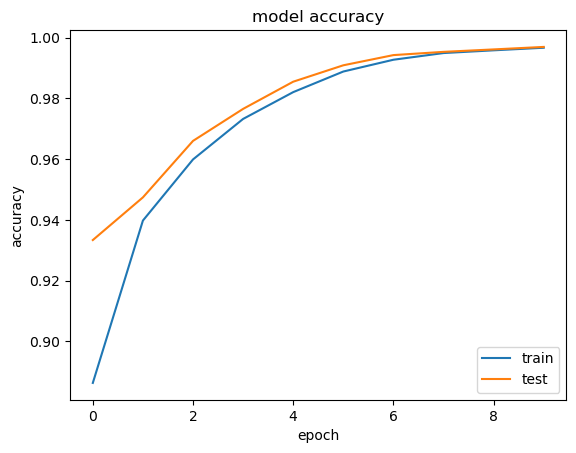

19/19 [==============================] - 1s 38ms/step - loss: 0.0151 - acc: 0.9972
Loss: 0.015057757496833801,
Accuracy: 0.997150182723999


In [19]:
model1 = create_run_model(300, 10, 'model1.pt')

In [20]:
report(model1,test_X,test_Y_padded)


19/19 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

       PROPN       1.00      1.00      1.00     52020
         ADP       0.99      0.99      0.99      1567
        NOUN       0.97      1.00      0.98      1434
        VERB       0.99      0.98      0.98      1166
         DET       0.97      0.96      0.97       629
        PRON       0.98      0.99      0.99       512
         AUX       0.98      0.98      0.98       392
         ADJ       0.93      0.99      0.96       256
         NUM       0.91      0.97      0.94       220
       CCONJ       0.97      0.91      0.94       127
         ADV       1.00      0.98      0.99       109
        PART       1.00      0.45      0.62        76
        INTJ       0.96      0.46      0.63        56
         SYM       1.00      1.00      1.00        36

    accuracy                           1.00     58600
   macro avg       0.98      0.91      0.93     58600
weighted avg       1.00   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          280200    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 15)          975       
 tributed)                                                       
                                                                 
Total params: 304,535
Trainable params: 304,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 5s 90ms/step - loss: 0.8898 - acc: 0.8594 - val_loss: 0.3823 - val_acc: 0.8935
Epoch 2/10
34/34 [==============================] - 3s 79ms/step - loss: 0.2888 - acc: 0.9392 - val_loss: 0.2232 - 

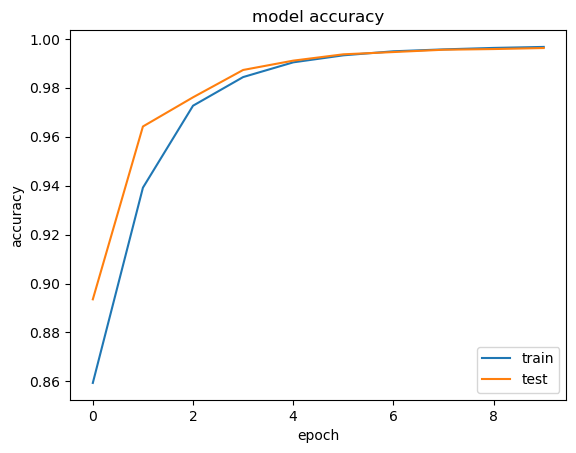

19/19 [==============================] - 0s 11ms/step - loss: 0.0174 - acc: 0.9963
Loss: 0.01740138791501522,
Accuracy: 0.9963481426239014


In [21]:
model2 = create_run_model2(300, 10, 'model2.pt')

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          280200    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 15)          975       
 tributed)                                                       
                                                                 
Total params: 304,535
Trainable params: 304,535
Non-trainable params: 0
_________________________________________________________________


In [23]:
report(model2,test_X,test_Y_padded)

19/19 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

       PROPN       1.00      1.00      1.00     52020
         ADP       0.98      0.99      0.99      1567
        NOUN       0.98      1.00      0.99      1434
        VERB       0.99      0.99      0.99      1166
         DET       0.98      0.96      0.97       629
        PRON       0.97      0.87      0.92       512
         AUX       0.85      0.98      0.91       392
         ADJ       0.93      0.98      0.95       256
         NUM       0.91      0.97      0.94       220
       CCONJ       0.99      0.85      0.92       127
         ADV       1.00      0.96      0.98       109
        PART       1.00      0.57      0.72        76
        INTJ       1.00      0.77      0.87        56
         SYM       1.00      1.00      1.00        36

    accuracy                           1.00     58600
   macro avg       0.97      0.92      0.94     58600
weighted avg       1.00   

#TEST

In [24]:
sentence = 'Mary had a little lamb'
predict_sentence_POS_Tags(sentence,model1,word_tokenizer,pos_tag_dict_rev)

NameError: name 'pos_tag_dict_rev' is not defined

In [ ]:
sentence = 'Mary had a little lamb'
predict_sentence_POS_Tags(sentence,model2,word_tokenizer,pos_tag_dict_rev)

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/model2.pt')

In [ ]:
model.summary()

In [ ]:
sentence = 'Mary had a little lamb'
predict_sentence_POS_Tags(sentence,model,word_tokenizer,id2tag)